In [16]:
import kagglehub
import pandas as pd
import os
from PIL import Image
import numpy as np
import torch 
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import seaborn as sns



# EDA


In [17]:
# Download latest version
path = kagglehub.dataset_download("gpreda/chinese-mnist")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
csv_file_path = f"{path}/chinese_mnist.csv"
dataDF = pd.read_csv(csv_file_path)


# Print the feature names (column names)
print("Feature names:", dataDF.columns.tolist())

Path to dataset files: /Users/quiet98k/.cache/kagglehub/datasets/gpreda/chinese-mnist/versions/7
Feature names: ['suite_id', 'sample_id', 'code', 'value', 'character']


In [18]:
IMAGE_PATH = f"{path}/data/data/"
print("image files :", len(os.listdir(IMAGE_PATH)))

# Add file name to the data frame
dataDF['file'] = dataDF[['suite_id','sample_id','code']].apply(lambda x: 'input_' + 
                 x['suite_id'].astype(str) +'_'+x['sample_id'].astype(str)+'_'+x['code'].astype(str)+'.jpg', axis=1)
dataDF.head(5)

# Characters list
characters = dataDF['character'].unique().tolist()
print(characters)
print(len(characters))



image files : 15000
['九', '十', '百', '千', '万', '亿', '零', '一', '二', '三', '四', '五', '六', '七', '八']
15


In [19]:
indexImage = 3000
imgPath =  os.path.join(IMAGE_PATH, dataDF['file'][indexImage]) 
im = Image.open(imgPath)
im.size
IMG_SIZE = im.size[0]

# Data Preparation

In [20]:
class ChineseMNISTdataset(Dataset):
    def __init__(self, annotations_dataframe, img_dir):
        self.df = annotations_dataframe
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        imgPath =  os.path.join(self.img_dir, self.df ['file'][idx]) 
        img = Image.open(imgPath)

        imgAsT = torch.from_numpy(np.array(img)).float()

        label = self.df['code'][idx] -1 # let's use the code as target variable
        
        return imgAsT, label

In [21]:
chineseNumbers = ChineseMNISTdataset(dataDF, IMAGE_PATH)  # init
chineseNumbers.__len__() # dataset length

15000

torch.Size([64, 64])
9
15000


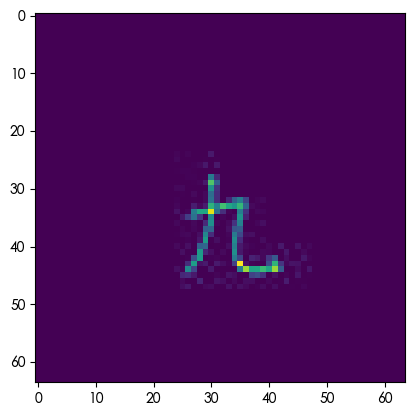

In [22]:
img, label = chineseNumbers.__getitem__(42)
print(img.shape)
print(label)
plt.imshow(img)
print(len(chineseNumbers))


# Split data for training and testing

In [23]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

In [24]:
testSize = chineseNumbers.__len__() // 10
trainSize = chineseNumbers.__len__() - testSize

trainDataset, testDataset = random_split(chineseNumbers, [trainSize, testSize])

len(trainDataset), len(testDataset)

(13500, 1500)

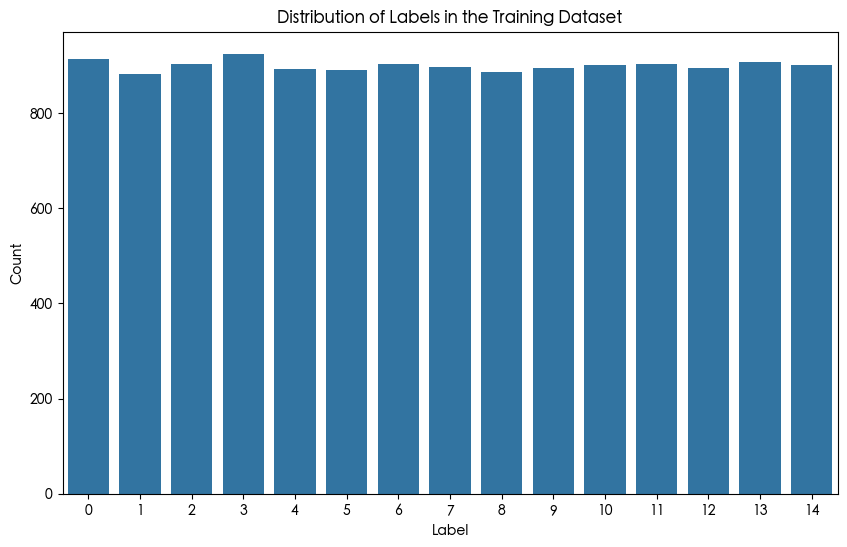

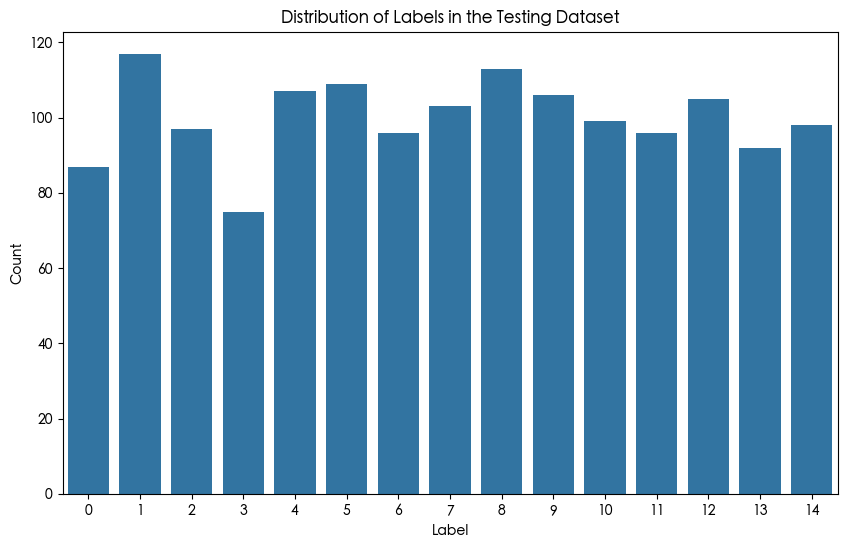

In [25]:
# Extract labels from the training dataset
train_labels = [trainDataset[i][1] for i in range(len(trainDataset))]

# Convert training labels to a pandas DataFrame
train_labels_df = pd.DataFrame(train_labels, columns=['label'])

# Extract labels from the testing dataset
test_labels = [testDataset[i][1] for i in range(len(testDataset))]

# Convert testing labels to a pandas DataFrame
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Visualize the distribution of the labels for the training dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_labels_df)
plt.title('Distribution of Labels in the Training Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Visualize the distribution of the labels for the testing dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test_labels_df)
plt.title('Distribution of Labels in the Testing Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [26]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Set a font that supports Chinese characters
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'  # Adjust the path if needed
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = prop.get_name()



labels_dict = {
    0: "零", 1: "一", 2: "二", 3: "三", 4: "四", 5: "五",
    6: "六", 7: "七", 8: "八", 9: "九", 10: "十",
    11: "百", 12: "千", 13: "万", 14: "亿"
}


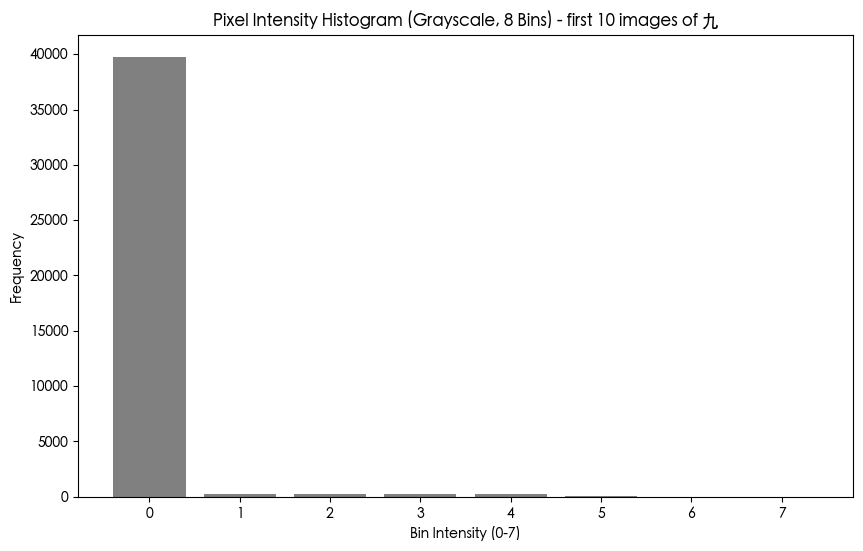

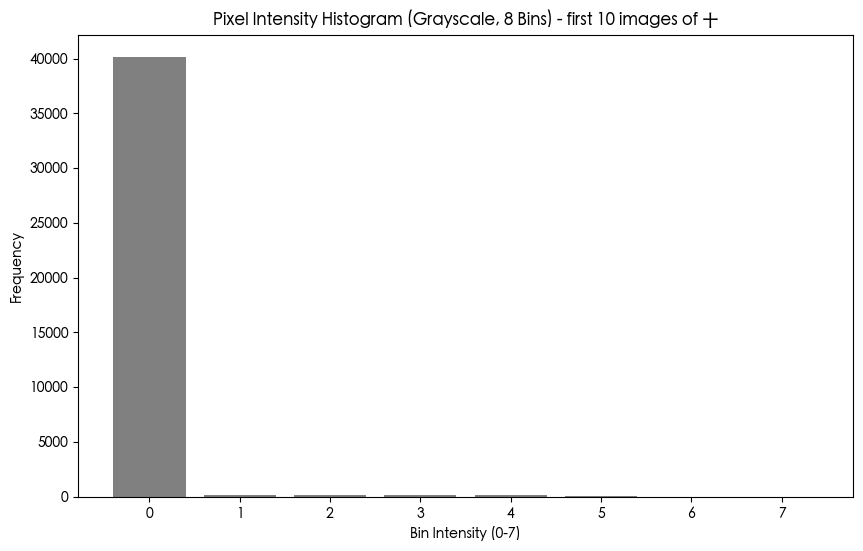

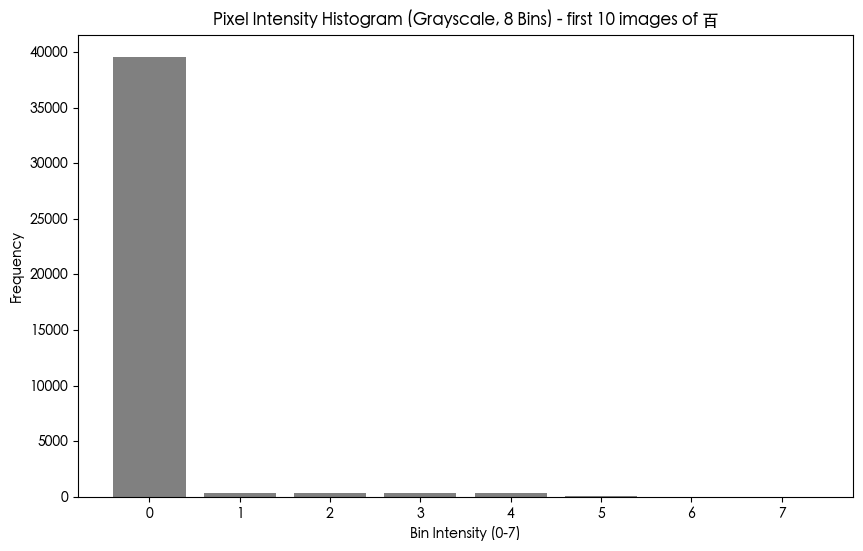

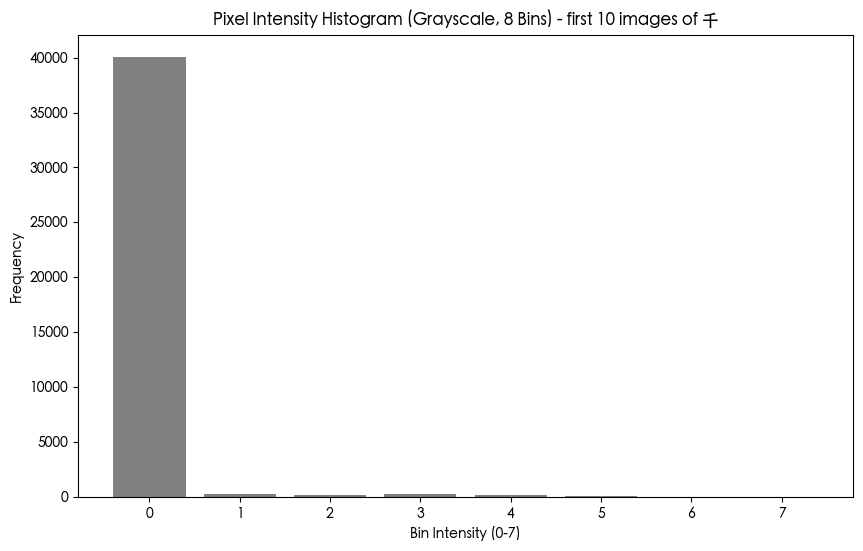

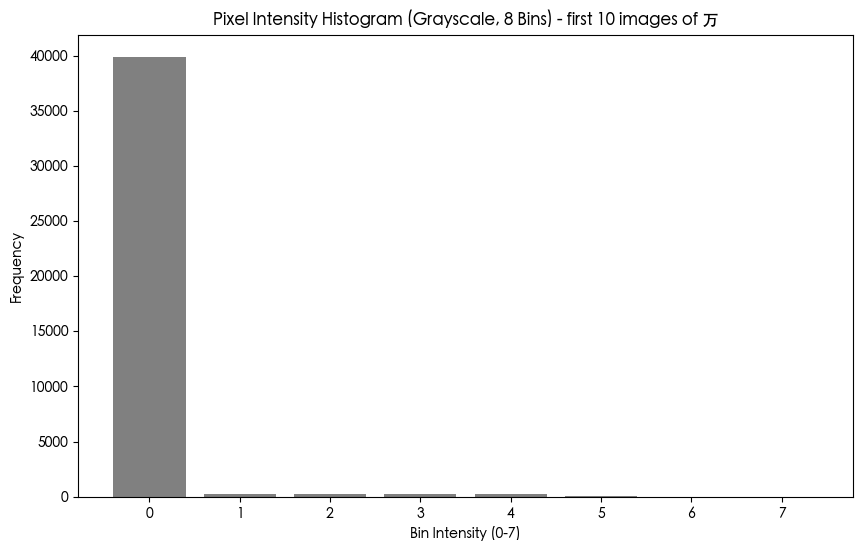

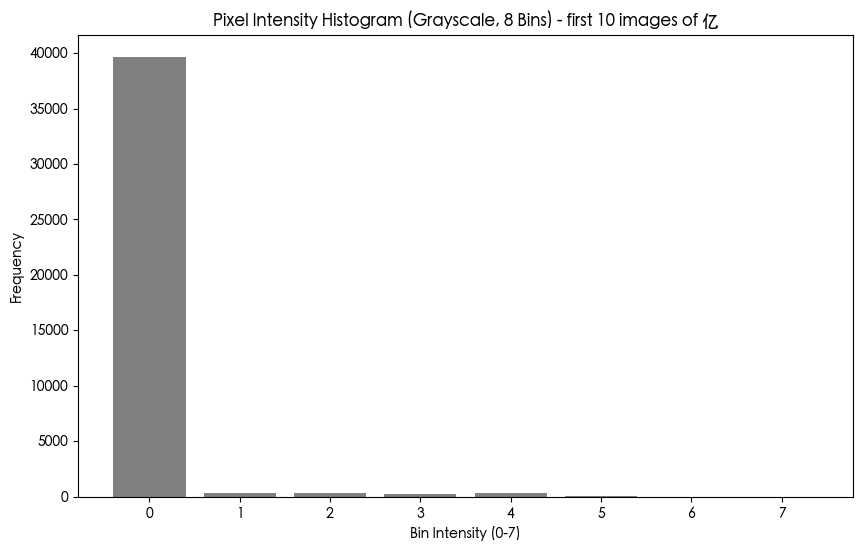

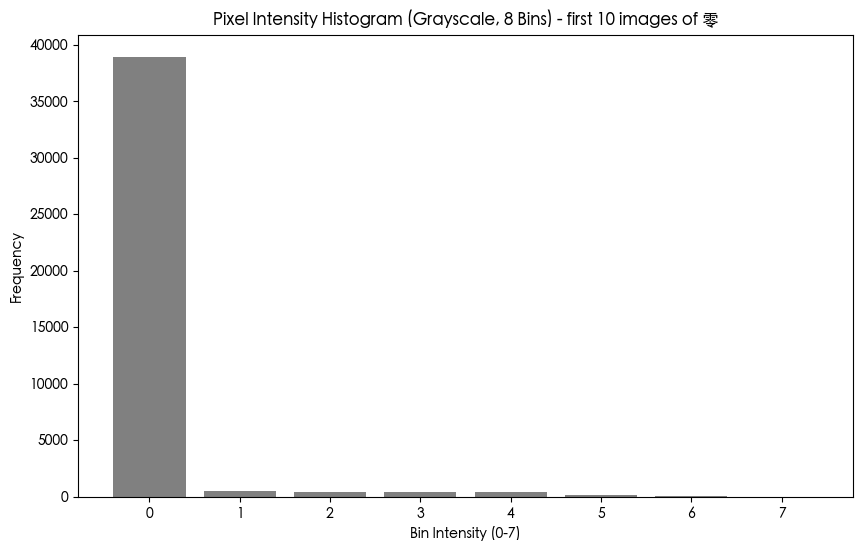

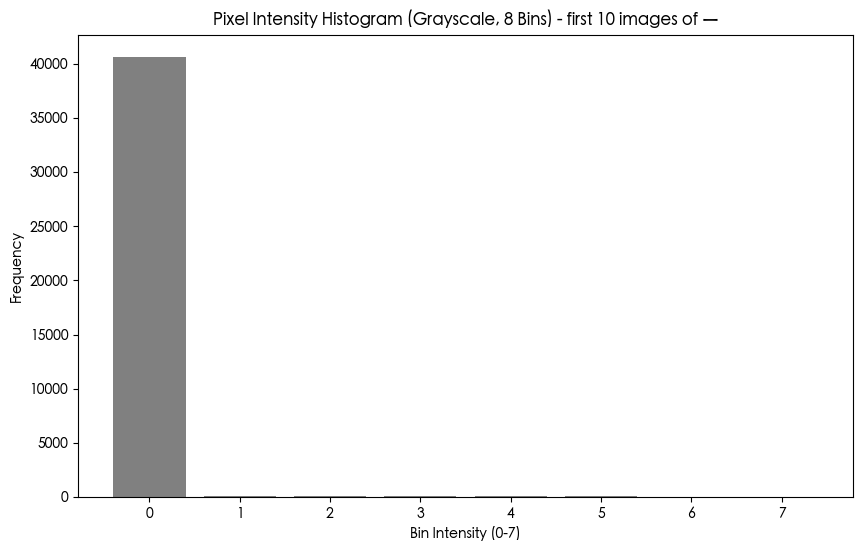

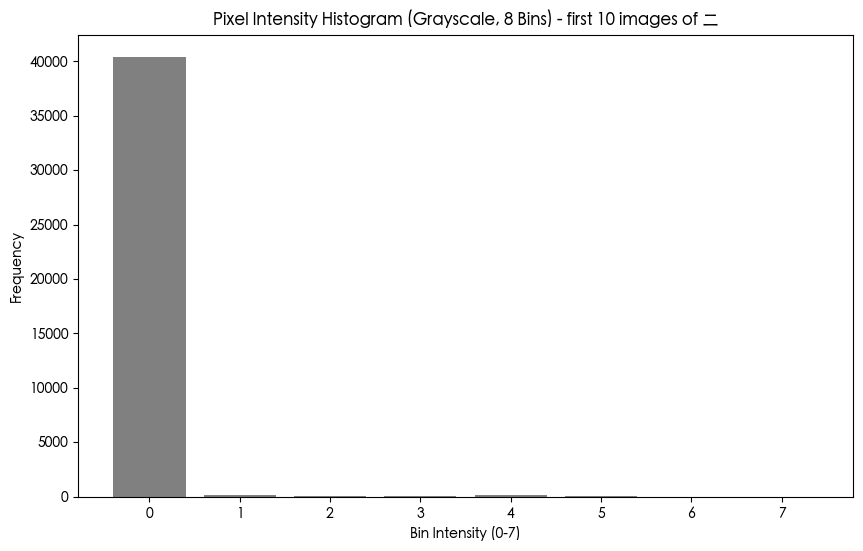

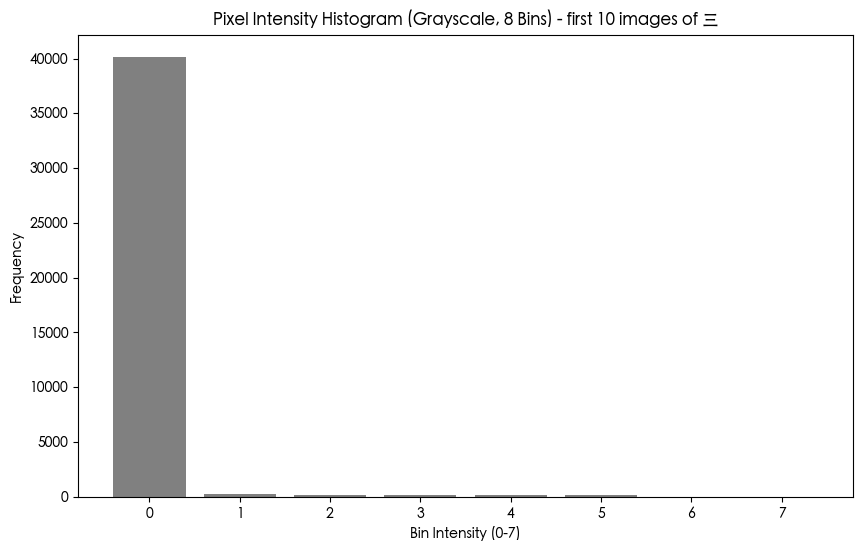

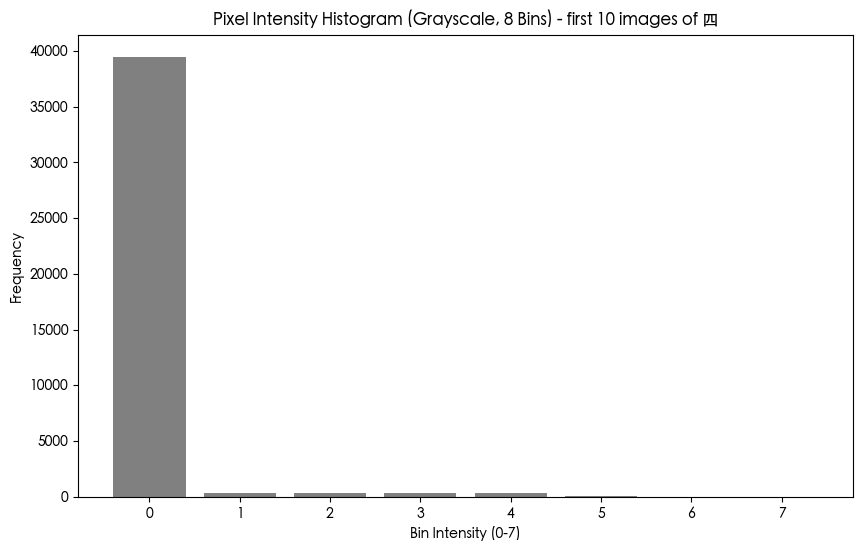

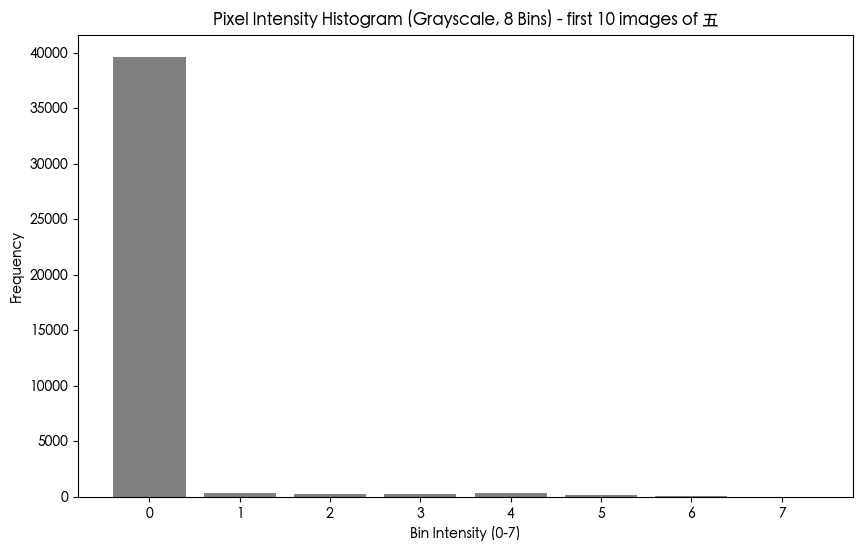

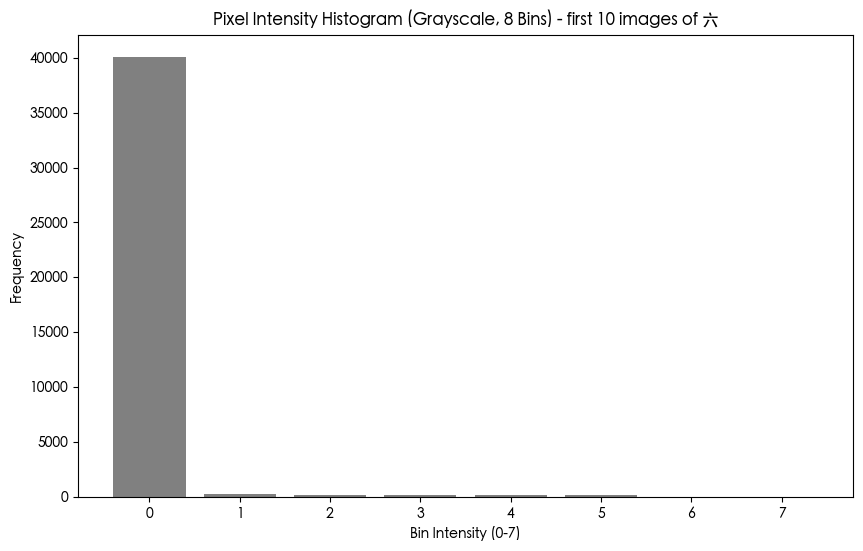

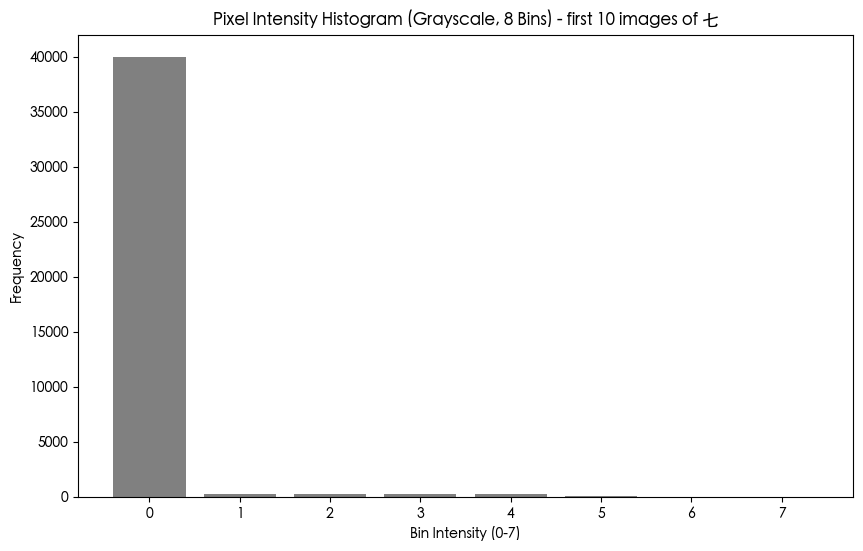

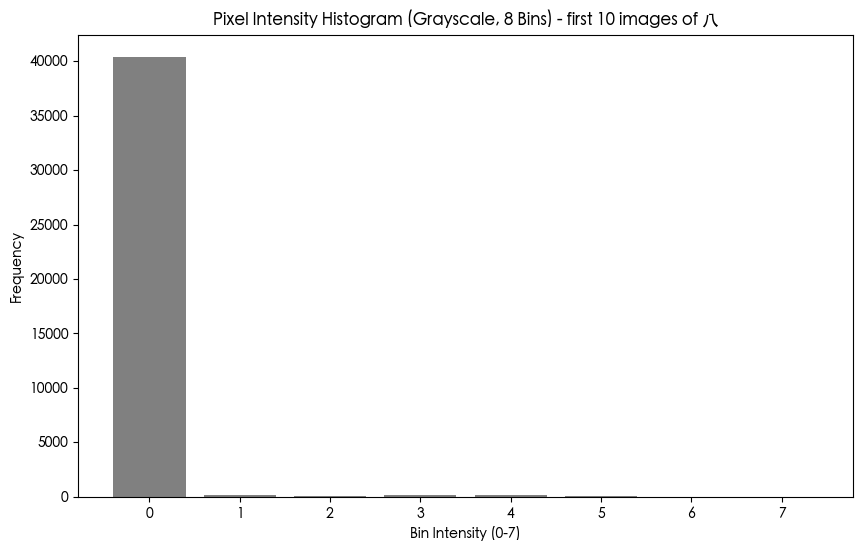

In [27]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(0, 15000, 1000):
    accumulated_hist = np.zeros(8)
    
    # Accumulate histogram for 10 images starting from each `i` value
    for j in range(i, i + 10):
        img, label = chineseNumbers.__getitem__(j)  # Get the numpy array for each image
        
        # Flatten the array to 1D for histogram calculation
        img_array = img.flatten()  # Flatten to ensure 1D array for histogram
        
        # Calculate the histogram with 8 bins over the full range of 0 to 255
        hist, _ = np.histogram(img_array, bins=8, range=(0, 256))
        accumulated_hist += hist
        
    # Plot the accumulated histogram for this batch of 10 images
    plt.figure(figsize=(10, 6))
    plt.bar(range(8), accumulated_hist, color='gray', tick_label=range(8)) 
    plt.xlabel('Bin Intensity (0-7)')
    plt.ylabel('Frequency')
    plt.title(f'Pixel Intensity Histogram (Grayscale, 8 Bins) - first 10 images of {labels_dict[label]}')
    plt.show()


## Sharpness and Edge Detection
- **Objective**: To detect inconsistencies in stroke sharpness and identify blurry or low-quality scans.
- **How**: Apply edge detection filters (such as Sobel or Canny) across a random subset of images. Calculate edge sharpness metrics, and examine if there’s a wide variance in edge clarity.
- **Outcome**: Reveals if any images may need filtering or quality adjustments to standardize sharpness, ensuring the model doesn’t learn unintended noise.

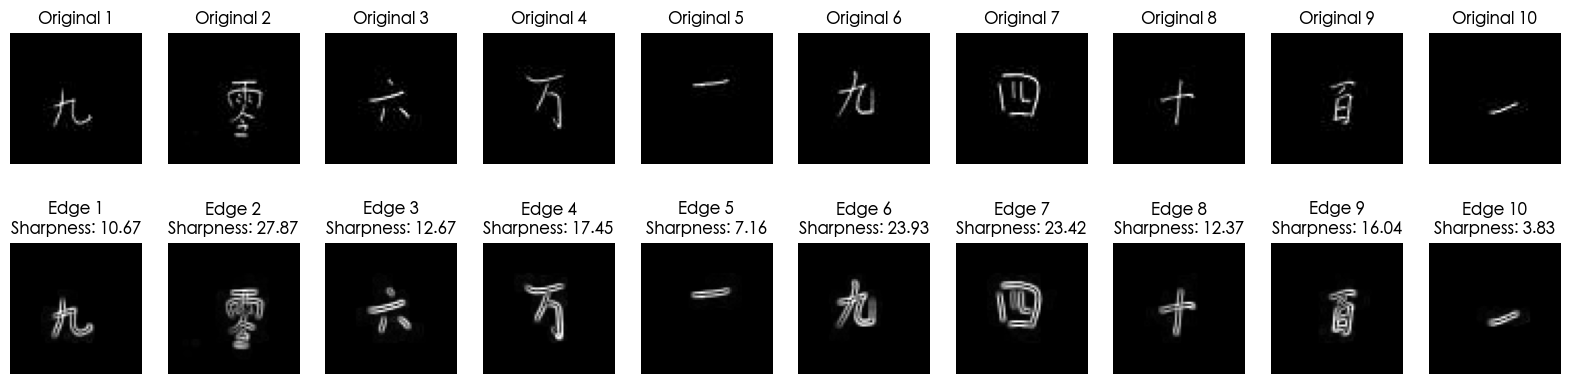

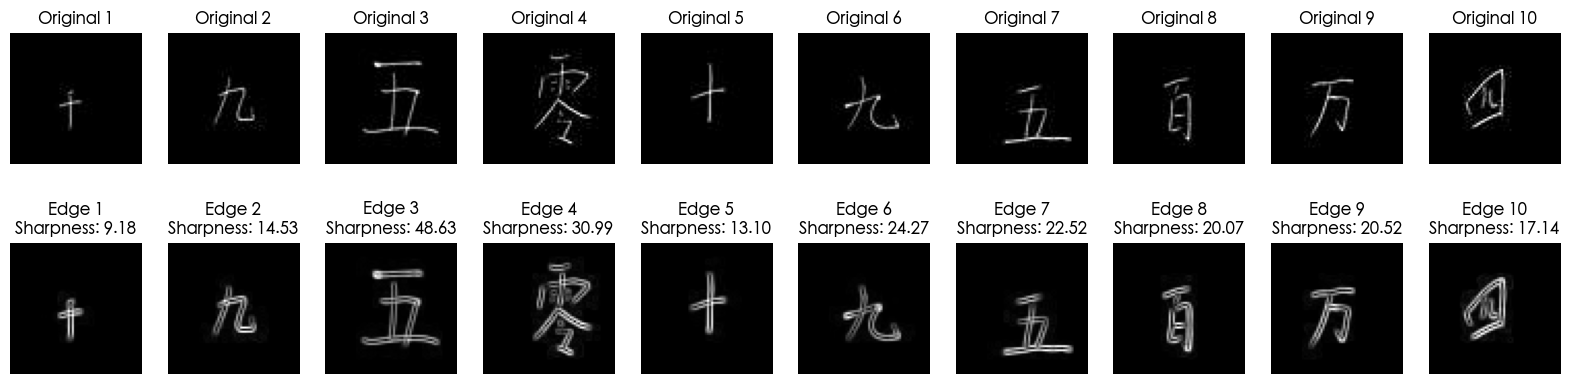

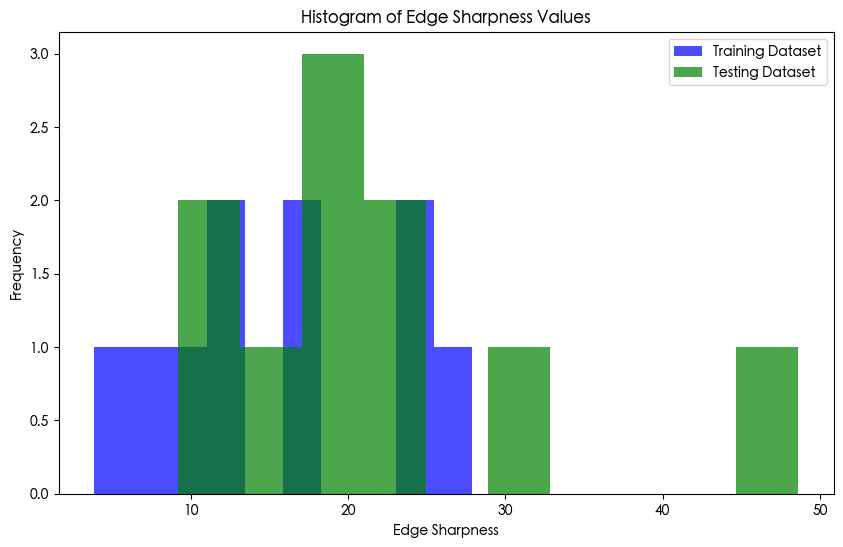

In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from torch.utils.data import DataLoader

# Function to apply Sobel filter and calculate edge sharpness
def calculate_edge_sharpness(image):
    sobel_x = sobel(image, axis=0)
    sobel_y = sobel(image, axis=1)
    edge_magnitude = np.hypot(sobel_x, sobel_y)
    return np.mean(edge_magnitude)

# Function to visualize edge detection on a random subset of images
def visualize_edge_detection(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 5))
    
    sharpness_values = []
    
    for i, idx in enumerate(indices):
        img, _ = dataset[idx]
        img_np = img.numpy()
        
        # Calculate edge sharpness
        sharpness = calculate_edge_sharpness(img_np)
        sharpness_values.append(sharpness)
        
        # Plot original image
        axes[0, i].imshow(img_np, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Original {i+1}')
        
        # Plot edge detection result
        sobel_x = sobel(img_np, axis=0)
        sobel_y = sobel(img_np, axis=1)
        edge_magnitude = np.hypot(sobel_x, sobel_y)
        axes[1, i].imshow(edge_magnitude, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Edge {i+1}\nSharpness: {sharpness:.2f}')
    
    plt.show()
    
    return sharpness_values

# Visualize edge detection on a random subset of training images
train_sharpness_values = visualize_edge_detection(trainDataset)

# Visualize edge detection on a random subset of testing images
test_sharpness_values = visualize_edge_detection(testDataset)

# Plot histogram of sharpness values for training and testing datasets
plt.figure(figsize=(10, 6))
plt.hist(train_sharpness_values, bins=10, color='blue', alpha=0.7, label='Training Dataset')
plt.hist(test_sharpness_values, bins=10, color='green', alpha=0.7, label='Testing Dataset')
plt.title('Histogram of Edge Sharpness Values')
plt.xlabel('Edge Sharpness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Intra-Character Consistency Check
- **Objective**: To examine the consistency of each character’s appearance across different samples and volunteers.
- **How**: Calculate the mean and standard deviation of pixel intensities for each character across all samples, visualizing the range to observe consistency. You might also create "mean" images for each character by averaging pixel values across all samples of a character.
- **Outcome**: This shows the typical appearance of each character and helps in understanding how much variation exists within the same character, which is useful for designing augmentations.

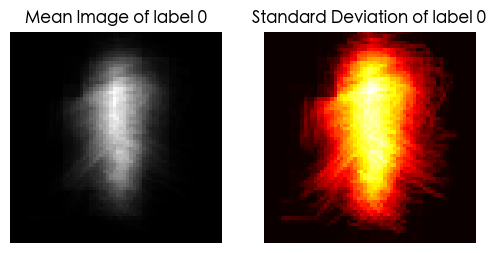

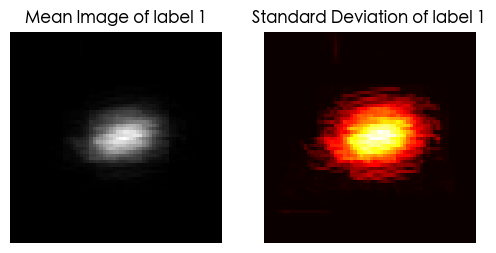

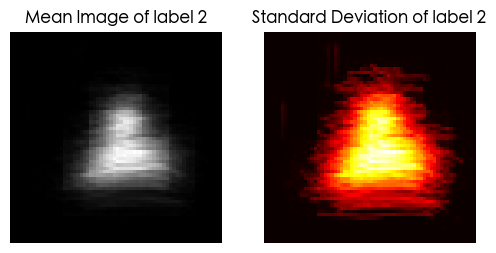

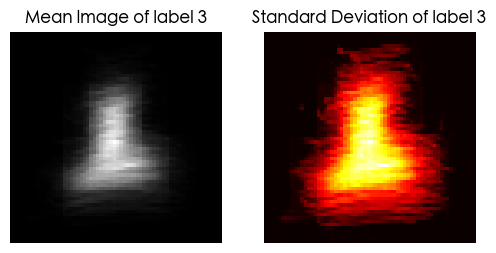

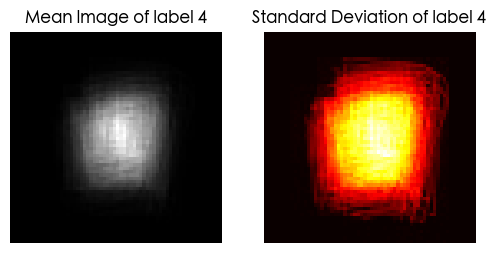

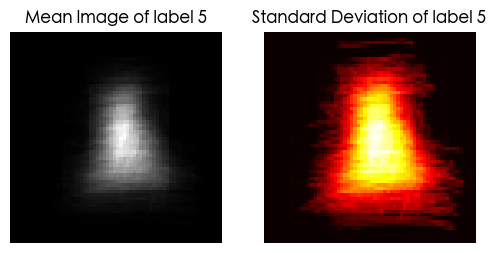

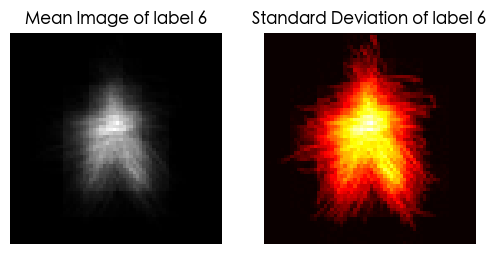

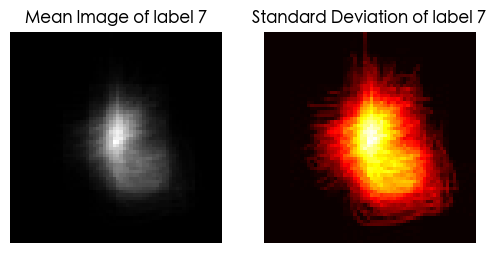

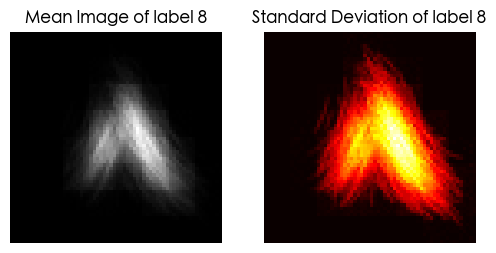

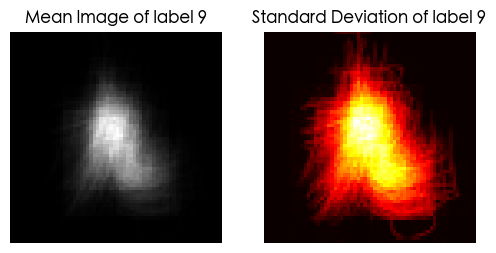

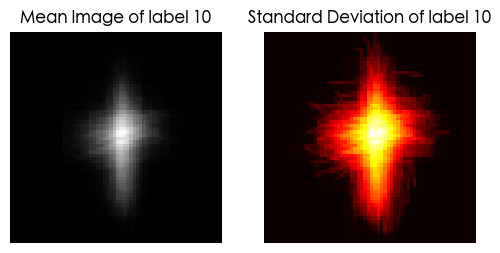

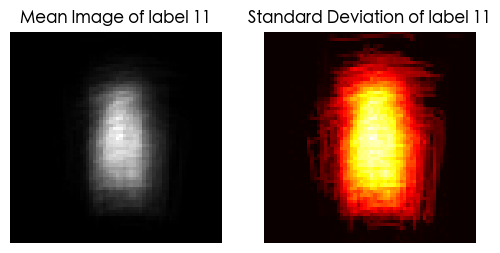

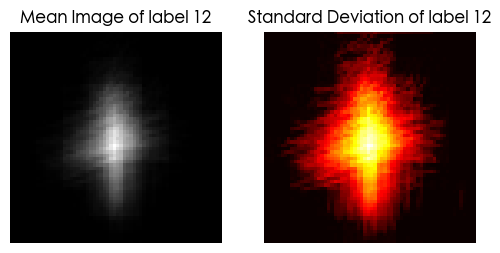

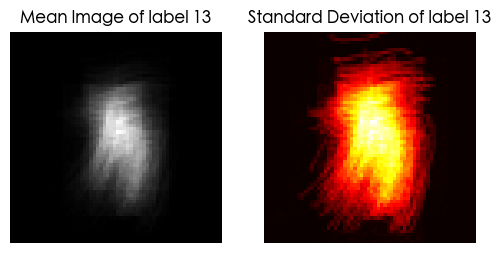

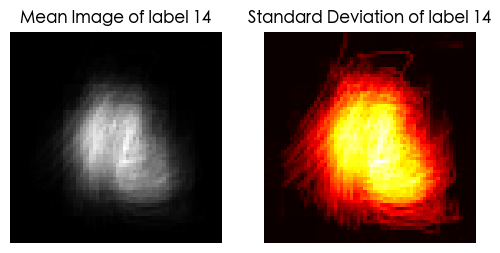

In [29]:
import numpy as np
import random
import matplotlib.pyplot as plt

mean_images = {}
st_dev_images = {}

# Loop through each character in the dataset
for character in range(len(characters)):
    character_img = []
    
    # Gather all images for the character in training dataset
    for i in range(len(trainDataset)):
        img, label = trainDataset[i]
        if label == character:
            character_img.append(img.numpy())

    # Skip if no images found for this character
    if len(character_img) == 0:
        print(f"No images found for character {character}")
        continue
    
    # Convert list of images to 3D numpy array (num_samples, height, width)
    character_img = np.array(character_img)
    
    # Calculate mean and standard deviation across the sample dimension
    mean_image = np.mean(character_img, axis=0)
    st_dev_image = np.std(character_img, axis=0)
    
    # Save mean and std images for this character
    mean_images[character] = mean_image
    st_dev_images[character] = st_dev_image
    
    # Plot the mean image to observe typical appearance of this character
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 2, 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f'Mean Image of label {character}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(st_dev_image, cmap='hot')
    plt.title(f'Standard Deviation of label {character}')
    plt.axis('off')
    
    plt.show()

# Augmentation Preview for Quality Assurance

- **Objective**: To assess the effect of augmentations on image quality and character integrity.
- **How**: Apply planned augmentations (rotations, scaling, translations) on a sample set of images and visually inspect them in a grid format for each character.
- **Outcome**: Ensures that augmentations preserve the integrity of each character, helping validate that these transformations won’t create distortions or unnatural examples for the model.


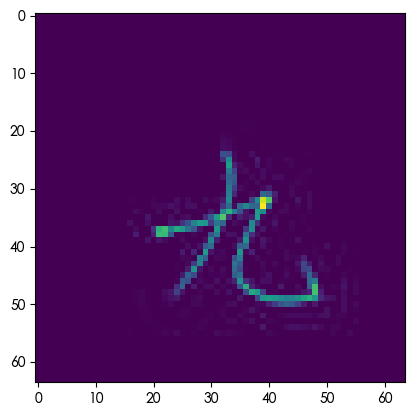

In [30]:
img, label = chineseNumbers.__getitem__(123)
plt.imshow(img)